In [1]:
!pip install trdg

     |████████████████████████████████| 91.2 MB 4.7 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 17.3 MB 34.9 MB/s            
  Created wheel for diffimg: filename=diffimg-0.2.3-py3-none-any.whl size=4049 sha256=066b5905a6c32a210d2b92f5365aca0270057159f2175c7e2e68a6ba97077e0f
  Stored in directory: /root/.cache/pip/wheels/6c/5d/60/bde2a959be56bca572bd67d49ebd52844d2ef933e85601dfa9
Successfully built diffimg
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda

# Text Recognition using CRNN

The Convolutional Recurrent Neural Networks is the combination of two of the most prominent neural networks, ie CNN(convolutional neural network) followed by the RNN(Recurrent neural networks). 

It can used for tasks such as Optical Character Recognition

In this notebook I've implemented a simple CRNN using CrossEntropy loss

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from trdg.generators import GeneratorFromDict
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

# Data Generation and Prepration

In [3]:
images = []
labels = []

os.mkdir('text_images')
n_images = 50_000
generator = GeneratorFromDict(count=n_images)
for img, lbl in tqdm(generator, total=n_images):
    path = f'text_images/{lbl}.png'
    img.save(path)
    images.append(path)
    labels.append(lbl)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [4]:
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

downsample_factor = 4

characters = set(char for label in labels for char in label)
max_length = max([len(label) for label in labels])

print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)
print("Maximum length of a word", max_length)

Number of unique characters:  54
Characters present:  {'x', 'P', "'", 'N', 'J', 'U', 'i', 'w', 'j', 'C', 'b', 'y', 'v', 'G', 'n', 'D', 'f', 'k', 'Q', 'a', 'g', 'F', 'h', 'E', 'R', 'e', 'I', 'z', 'A', 'L', 'o', 'S', 'T', 'l', 'B', 't', 'M', 'Z', 'q', 's', 'd', 'H', 'c', 'O', 'W', 'u', 'r', 'm', 'V', '.', 'X', 'p', '-', 'K'}
Maximum length of a word 22


In [5]:
char_to_num = {char: idx+1 for idx, char in enumerate(sorted(characters))}
num_to_char = {idx+1:char for idx, char in enumerate(sorted(characters))}

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(np.array(images), np.array(labels), test_size=0.1)

In [7]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = pad_sequences(
        [[char_to_num[char] for char in label]], maxlen=img_width//downsample_factor, padding='post'
    )
    return {"image": img, "label": label}


In [8]:
train_images = []
train_labels = []
for img, lbl in zip(x_train, y_train):
    encoded = encode_single_sample(img, lbl)
    train_images.append(encoded['image'])
    train_labels.append(encoded['label'])
    
valid_images = []
valid_labels = []
for img, lbl in zip(x_valid, y_valid):
    encoded = encode_single_sample(img, lbl)
    valid_images.append(encoded['image'])
    valid_labels.append(encoded['label'])    

2022-03-02 07:15:49.389341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 07:15:49.525508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 07:15:49.526736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 07:15:49.532671: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

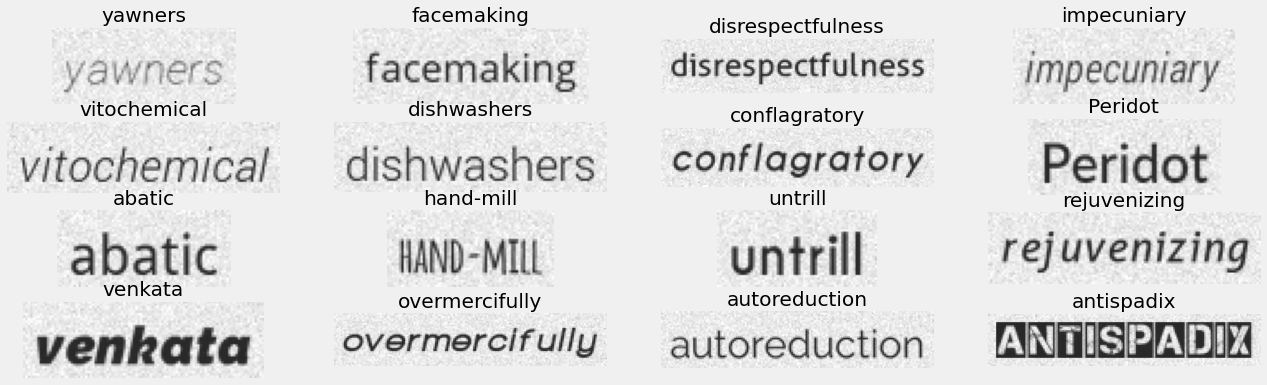

In [9]:
_, ax = plt.subplots(4, 4, figsize=(20, 6))
for i, (images, labels) in enumerate(zip(x_train[:16], y_train[:16])):
    ax[i // 4, i % 4].imshow(plt.imread(images), cmap="gray")
    ax[i // 4, i % 4].set_title(labels)
    ax[i // 4, i % 4].axis("off")
plt.show()

# Model

Model: "crnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            49216  

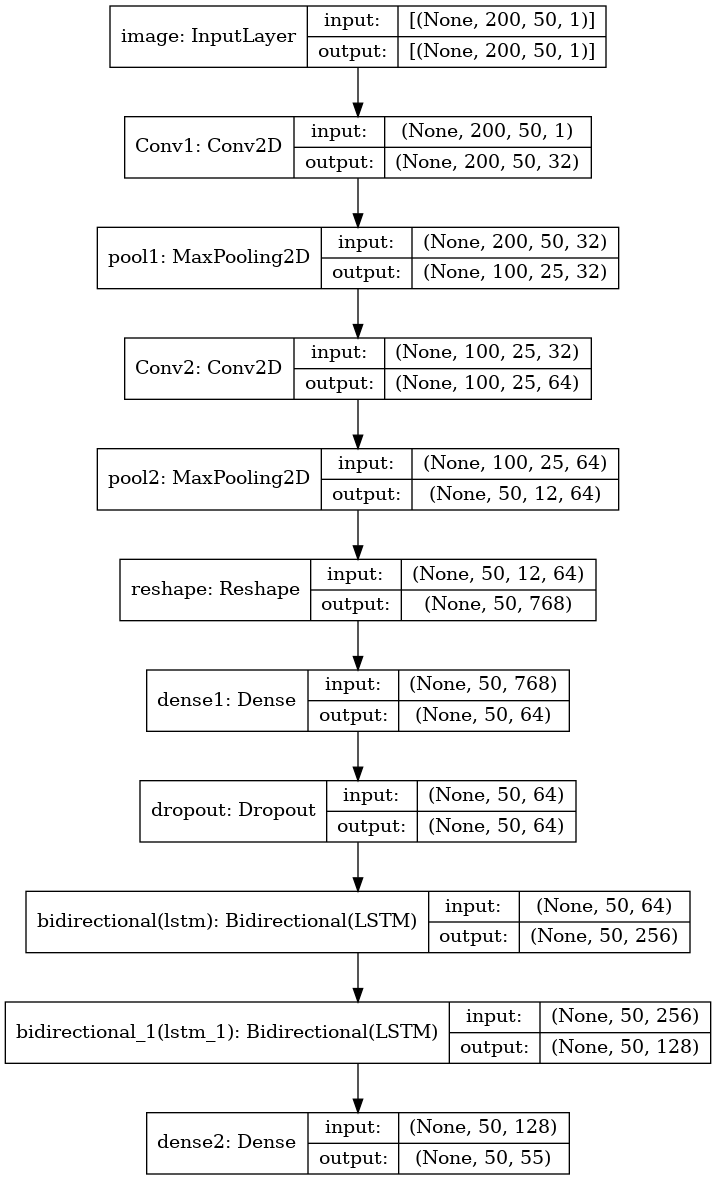

In [10]:
input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")

x = layers.Conv2D(
    32,
    (3, 3),
    activation="relu",
    padding="same",
    name="Conv1",
)(input_img)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)

x = layers.Conv2D(
    64,
    (3, 3),
    activation="relu",
    padding="same",
    name="Conv2",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)

new_shape = ((img_width // downsample_factor), (img_height // downsample_factor) * 64)
x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
x = layers.Dense(64, activation="relu", name="dense1")(x)
x = layers.Dropout(0.2)(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

output = layers.Dense(
    len(char_to_num) + 1, activation="softmax", name="dense2"
)(x)

model = keras.models.Model(
    inputs=input_img, outputs=output, name="crnn"
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()
keras.utils.plot_model(model, show_shapes=True)

# Training

In [11]:
epochs = 500
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True, verbose=1
)


history = model.fit(
    np.array(train_images), np.array(train_labels),
    validation_data=(np.array(valid_images), np.array(valid_labels)),
    epochs=epochs,
    callbacks=[early_stopping],
)

2022-03-02 07:17:17.594647: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1800000000 exceeds 10% of free system memory.
2022-03-02 07:17:19.305421: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1800000000 exceeds 10% of free system memory.
2022-03-02 07:17:20.630399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-03-02 07:17:28.117947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1407/1407 [==============================] - 49s 25ms/step - loss: 0.6211 - val_loss: 0.5608
Epoch 2/500
1407/1407 [==============================] - 33s 24ms/step - loss: 0.5335 - val_loss: 0.4694
Epoch 3/500
1407/1407 [==============================] - 34s 24ms/step - loss: 0.4218 - val_loss: 0.3254
Epoch 4/500
1407/1407 [==============================] - 33s 24ms/step - loss: 0.3052 - val_loss: 0.2053
Epoch 5/500
1407/1407 [==============================] - 34s 24ms/step - loss: 0.2154 - val_loss: 0.1266
Epoch 6/500
1407/1407 [==============================] - 34s 24ms/step - loss: 0.1517 - val_loss: 0.0698
Epoch 7/500
1407/1407 [==============================] - 33s 24ms/step - loss: 0.1092 - val_loss: 0.0404
Epoch 8/500
1407/1407 [==============================] - 34s 24ms/step - loss: 0.0817 - val_loss: 0.0222
Epoch 9/500
1407/1407 [==============================] - 34s 24ms/step - loss: 0.0621 - val_loss: 0.0185
Epoch 10/500
1407/1407 [==============================] - 34s 24ms/

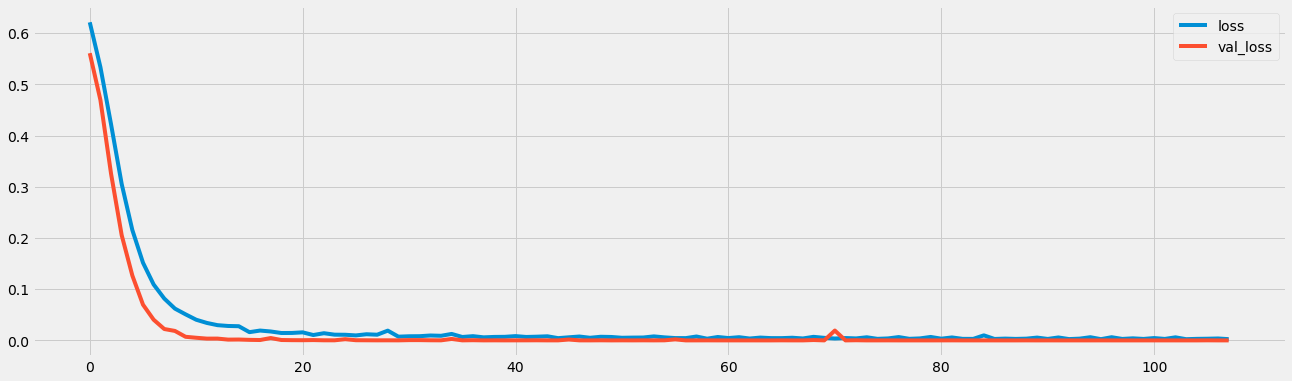

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).plot(ax=ax);

# Inference

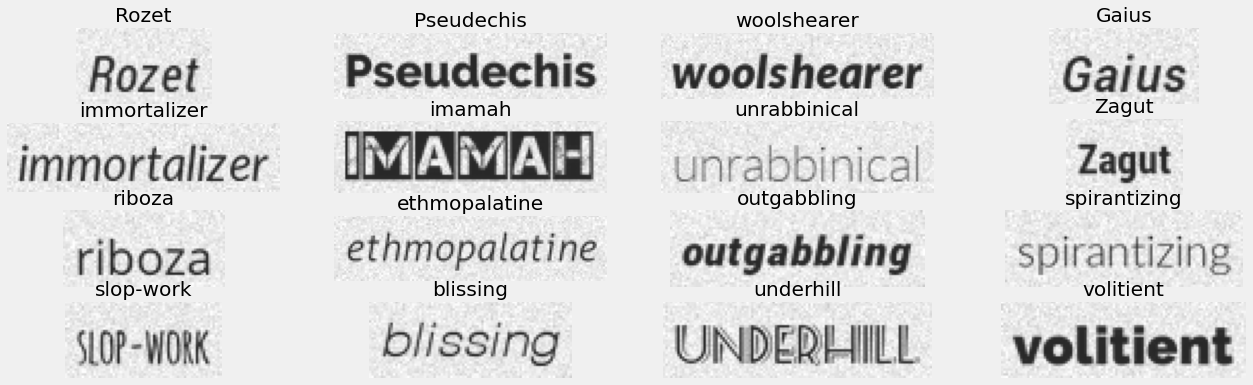

In [13]:
y_preds = model(np.array(valid_images)[:16]).numpy().argmax(axis=-1)
y_preds = [''.join([num_to_char.get(num, '') for num in pred]) for pred in y_preds]

_, ax = plt.subplots(4, 4, figsize=(20, 6))
for i, (images, labels) in enumerate(zip(x_valid[:16], y_preds[:16])):
    ax[i // 4, i % 4].imshow(plt.imread(images), cmap="gray")
    ax[i // 4, i % 4].set_title(labels)
    ax[i // 4, i % 4].axis("off")
plt.show()
